# Import Libraries and Data

In [12]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [13]:
train = pd.read_csv('/kaggle/input/playground-series-s6e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s6e1/test.csv')

# Data Overview

In [14]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Compute values that are constant across columns
    total_rows = len(df)
    duplicates = df.duplicated().sum()

    # Use vectorized operations 
    dtypes = df.dtypes
    instances = df.count()
    unique = df.nunique()
    sum_null = df.isnull().sum()
    #null_percentage = (df.isnull().sum() / total_rows * 100).round(2)

    # Create the summary 
    df_check = pd.DataFrame({
        #'column': df.columns,
        'dtype': dtypes,
        'instances': instances,
        'unique': unique,
        'sum_null': sum_null,
        #'null_percentage': null_percentage,
        'duplicates': duplicates  
    })

    return df_check

print("Train Data")
display(check(train))
display(train.head())

print("Test Data")
display(check(test))
display(test.head())

Train Data


,dtype,instances,unique,sum_null,duplicates
id,int64,630000,630000,0,0
age,int64,630000,8,0,0
gender,object,630000,3,0,0
course,object,630000,7,0,0
study_hours,float64,630000,792,0,0
class_attendance,float64,630000,617,0,0
internet_access,object,630000,2,0,0
sleep_hours,float64,630000,66,0,0
sleep_quality,object,630000,3,0,0
study_method,object,630000,5,0,0


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


Test Data


,dtype,instances,unique,sum_null,duplicates
id,int64,270000,270000,0,0
age,int64,270000,8,0,0
gender,object,270000,3,0,0
course,object,270000,7,0,0
study_hours,float64,270000,786,0,0
class_attendance,float64,270000,604,0,0
internet_access,object,270000,2,0,0
sleep_hours,float64,270000,64,0,0
sleep_quality,object,270000,3,0,0
study_method,object,270000,5,0,0


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy
2,630002,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,medium,moderate
3,630003,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,medium,moderate
4,630004,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,low,moderate


# Explore Data and Insights

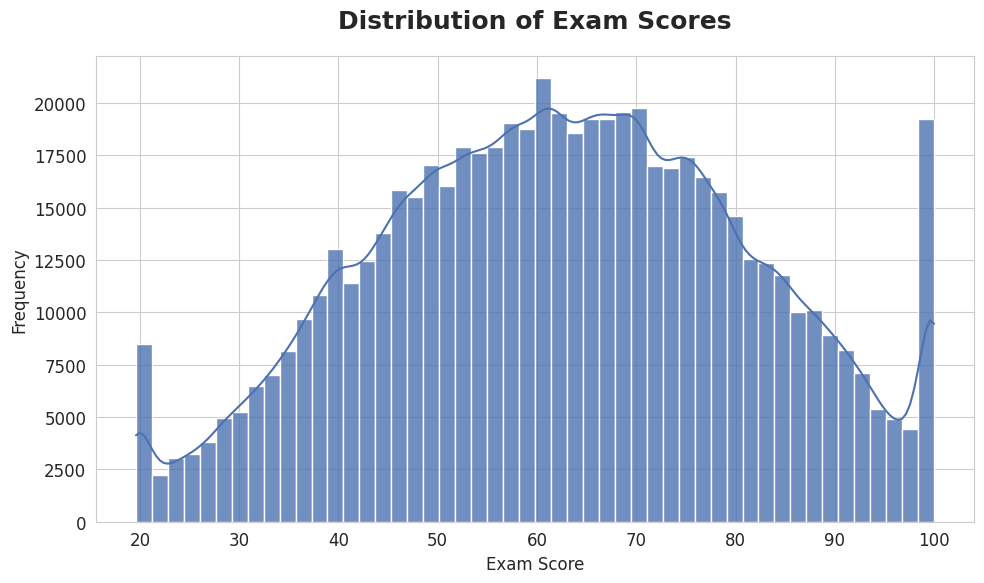

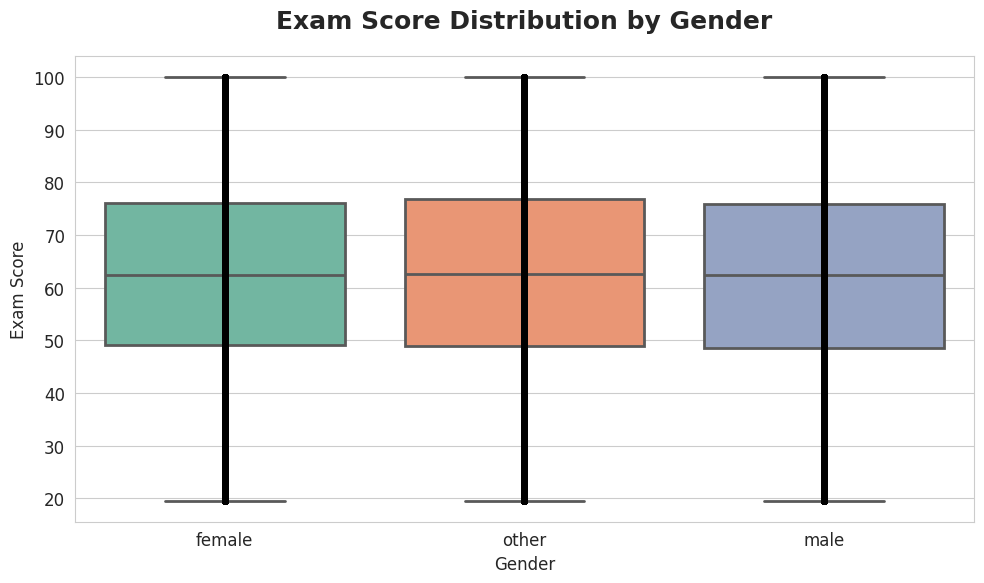

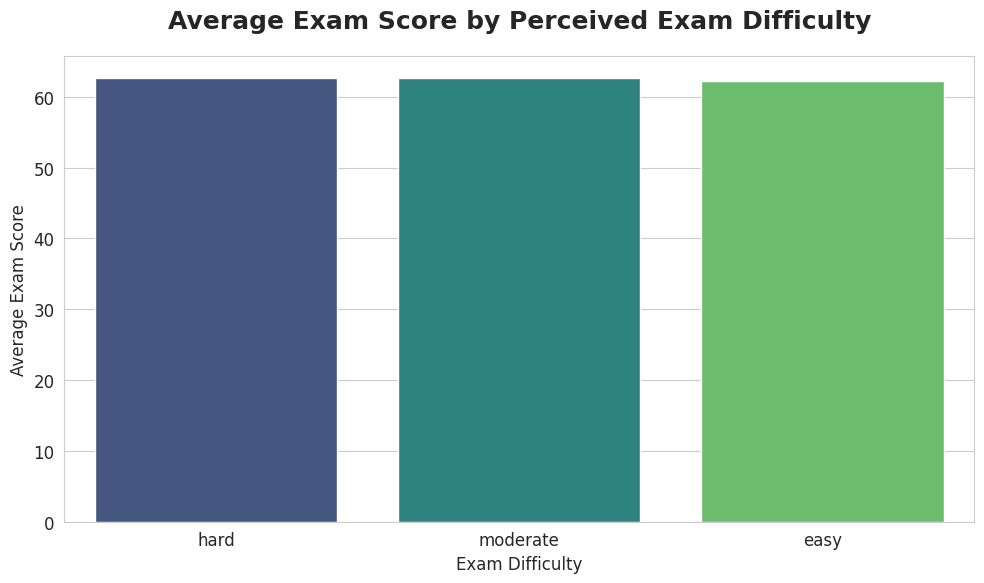

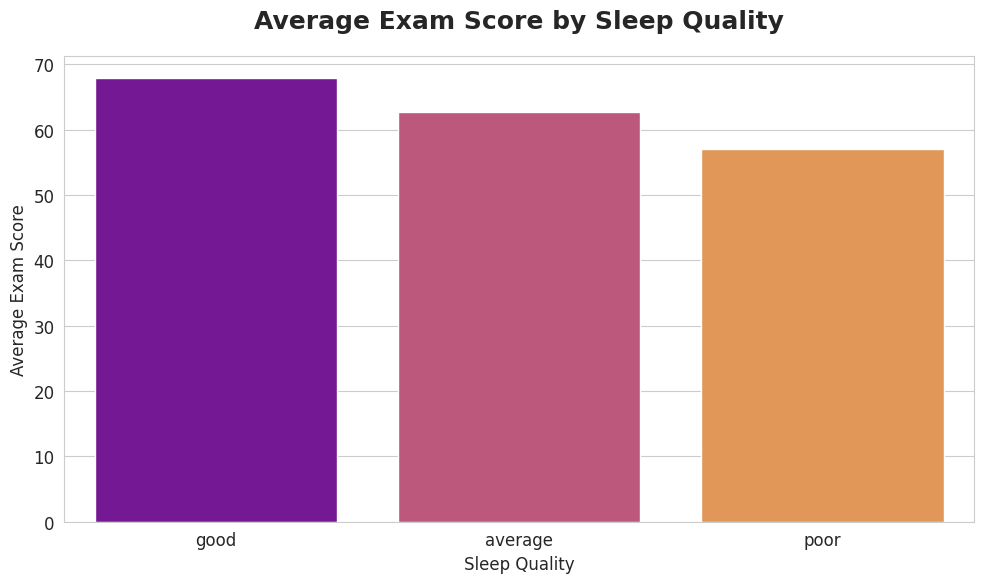

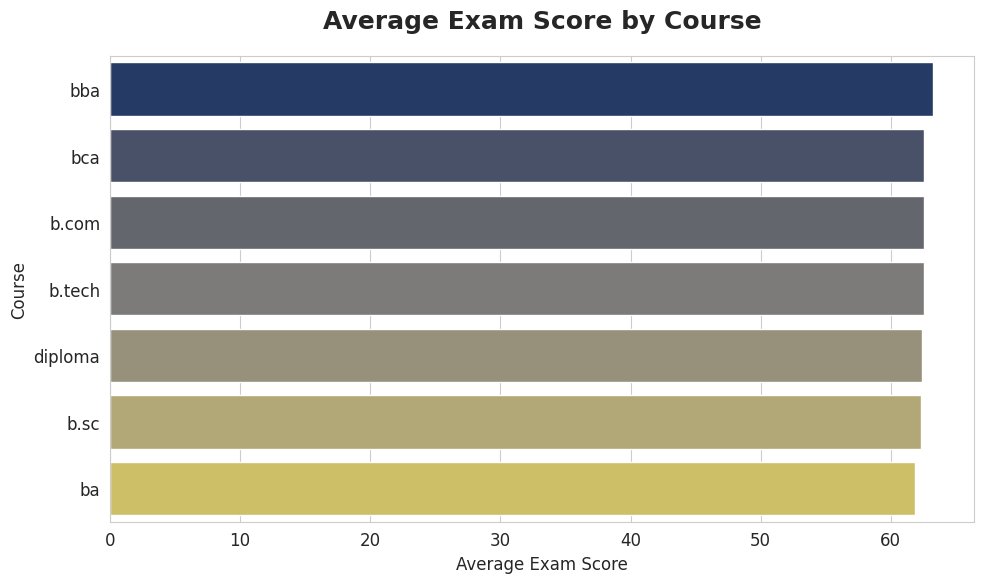

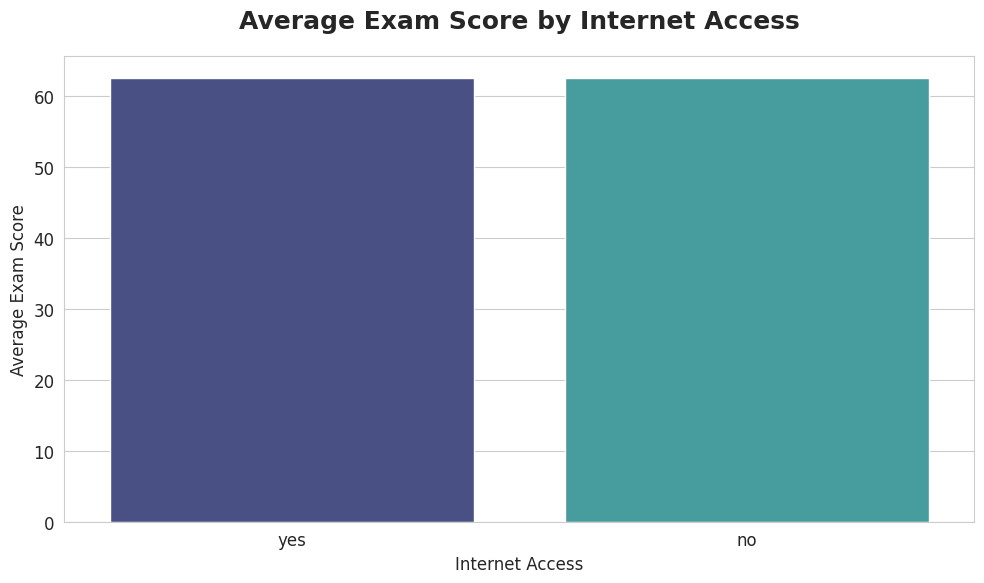

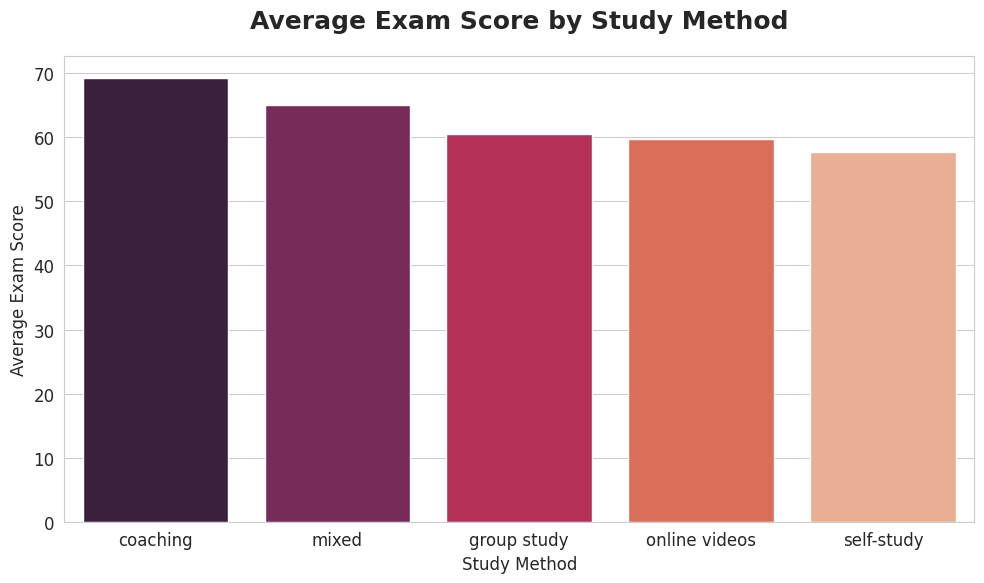

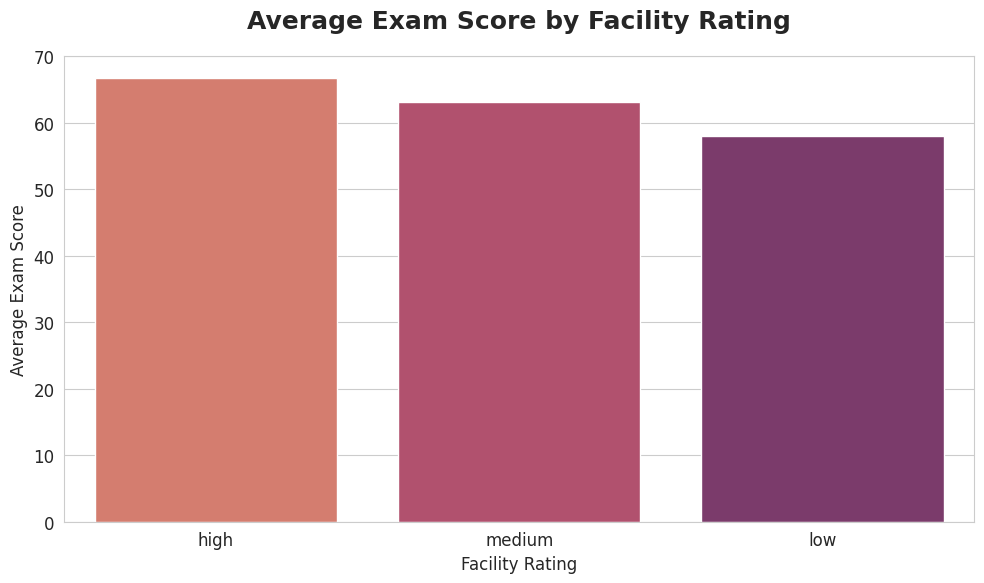

In [17]:
# Set style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Distribution of Exam Scores
plt.figure()
sns.histplot(train['exam_score'], kde=True, bins=50, color='#4c72b0', alpha=0.8)
plt.title('Distribution of Exam Scores', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Exam Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Exam Score by Gender
plt.figure()
sns.boxplot(x='gender', y='exam_score', data=train, palette="Set2", linewidth=2.0)
sns.stripplot(x='gender', y='exam_score', data=train, color='black', alpha=0.2, jitter=False)
plt.title('Exam Score Distribution by Gender', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Gender')
plt.ylabel('Exam Score')
plt.tight_layout()
plt.show()


# Average Exam Score by Exam Difficulty
difficulty_order = train.groupby('exam_difficulty')['exam_score'].mean().sort_values(ascending=False).index
plt.figure()
sns.barplot(
    x='exam_difficulty', y='exam_score', data=train,
    order=difficulty_order, palette="viridis", ci=None
)
plt.title('Average Exam Score by Perceived Exam Difficulty', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Exam Difficulty')
plt.ylabel('Average Exam Score')
plt.tight_layout()
plt.show()

# Average Exam Score by Sleep Quality
sleep_order = train.groupby('sleep_quality')['exam_score'].mean().sort_values(ascending=False).index
plt.figure()
sns.barplot(
    x='sleep_quality', y='exam_score', data=train,
    order=sleep_order, palette="plasma", ci=None
)
plt.title('Average Exam Score by Sleep Quality', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Sleep Quality')
plt.ylabel('Average Exam Score')
plt.tight_layout()
plt.show()

# Average Exam Score by Course
course_order = train.groupby('course')['exam_score'].mean().sort_values(ascending=False).index
plt.figure()
sns.barplot(x='exam_score', y='course', data=train, order=course_order, palette="cividis", errorbar=None)
plt.title('Average Exam Score by Course', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Average Exam Score')
plt.ylabel('Course')
plt.tight_layout()
plt.show()

# Average Exam Score by Internet Access
internet_order = train.groupby('internet_access')['exam_score'].mean().sort_values(ascending=False).index
plt.figure()
sns.barplot(x='internet_access', y='exam_score', data=train, order=internet_order, palette="mako", errorbar=None)
plt.title('Average Exam Score by Internet Access', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Internet Access')
plt.ylabel('Average Exam Score')
plt.tight_layout()
plt.show()

# Average Exam Score by Study Method
method_order = train.groupby('study_method')['exam_score'].mean().sort_values(ascending=False).index
plt.figure()
sns.barplot(x='study_method', y='exam_score', data=train, order=method_order, palette="rocket", errorbar=None)
plt.title('Average Exam Score by Study Method', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Study Method')
plt.ylabel('Average Exam Score')
plt.tight_layout()
plt.show()

# Average Exam Score by Facility Rating
facility_order = train.groupby('facility_rating')['exam_score'].mean().sort_values(ascending=False).index
plt.figure()
sns.barplot(x='facility_rating', y='exam_score', data=train, order=facility_order, palette="flare", errorbar=None)
plt.title('Average Exam Score by Facility Rating', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Facility Rating')
plt.ylabel('Average Exam Score')
plt.tight_layout()
plt.show()

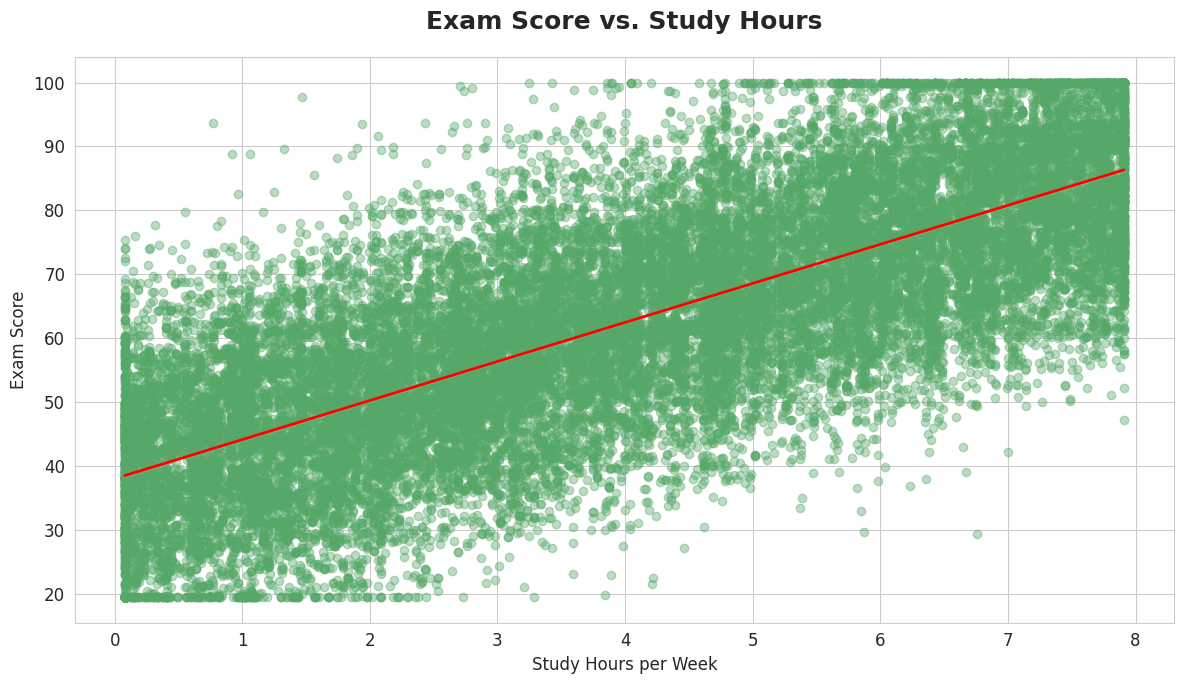

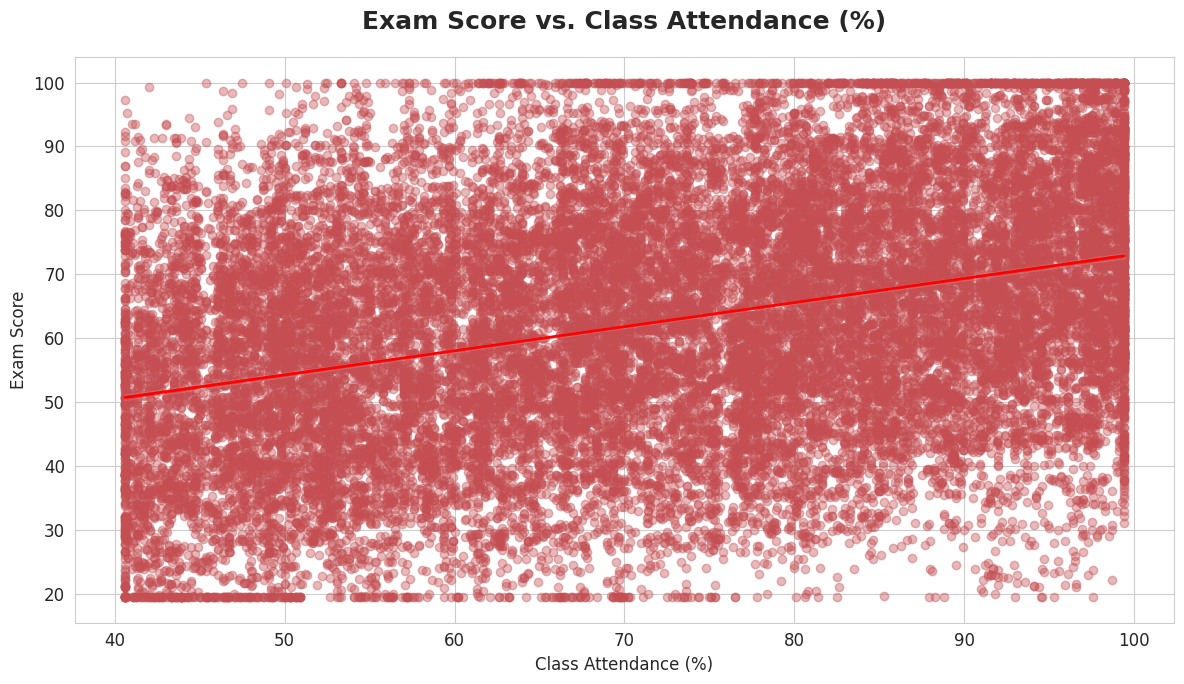

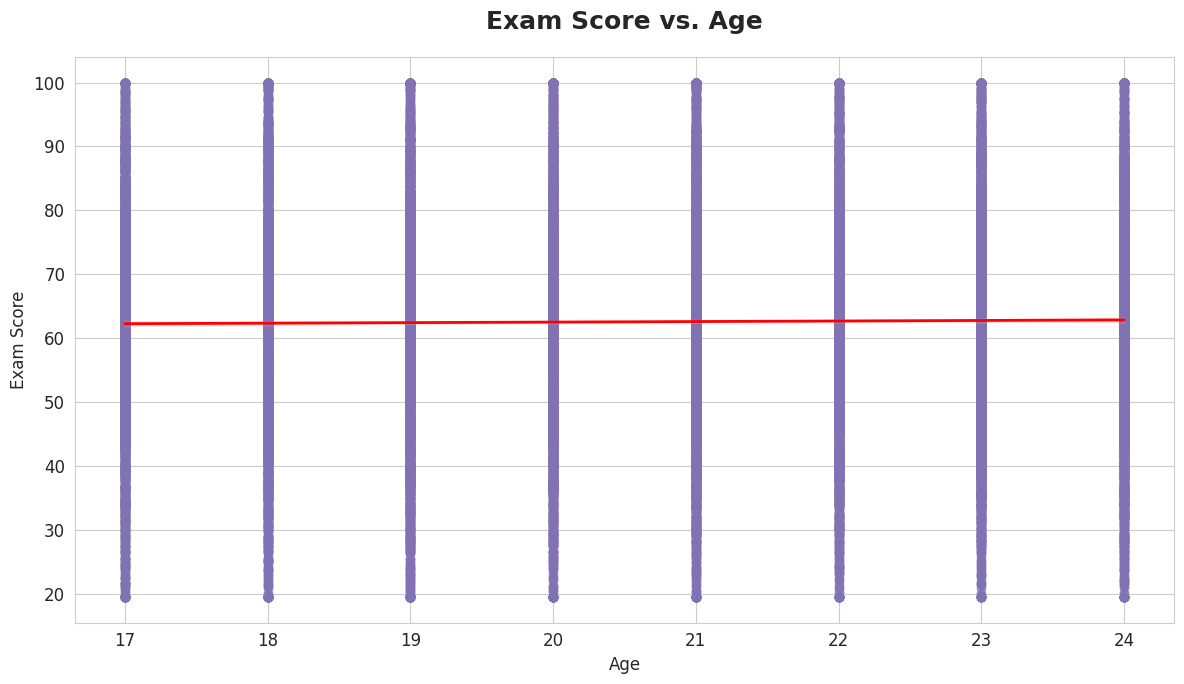

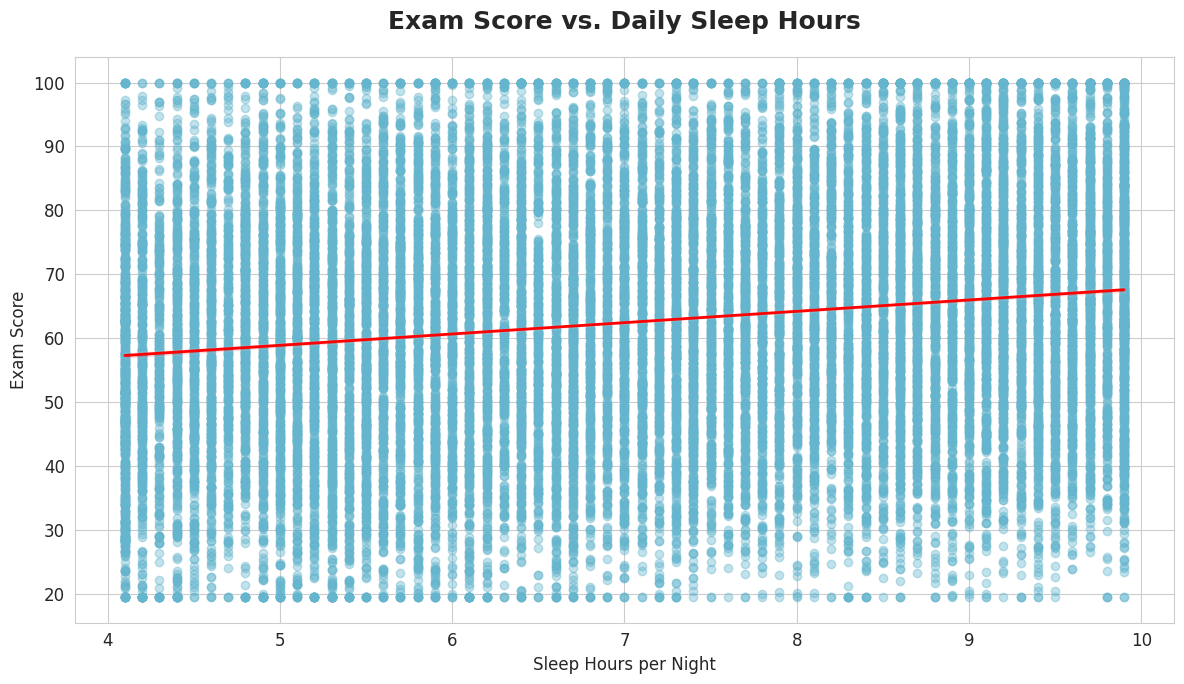

In [19]:
# Sample
plot_data = train.sample(n=30000, random_state=42)

# Settings
scatter_kws = {'alpha': 0.4, 'color': '#55a868', 'rasterized': True}
line_kws = {'color': 'red', 'linewidth': 2}

plt.rcParams['figure.figsize'] = (12, 7)

# Exam Score vs. Study Hours
plt.figure()
sns.regplot(x='study_hours', y='exam_score', data=plot_data,
            lowess=False, scatter_kws=scatter_kws, line_kws=line_kws)
plt.title('Exam Score vs. Study Hours', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Study Hours per Week')
plt.ylabel('Exam Score')
plt.tight_layout()
plt.show()

# Exam Score vs. Class Attendance
plt.figure()
sns.regplot(x='class_attendance', y='exam_score', data=plot_data,
            lowess=False, 
            scatter_kws={'alpha': 0.4, 'color': '#c44e52', 'rasterized': True},
            line_kws=line_kws)
plt.title('Exam Score vs. Class Attendance (%)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Class Attendance (%)')
plt.ylabel('Exam Score')
plt.tight_layout()
plt.show()

# Exam Score vs. Age
plt.figure()
sns.regplot(x='age', y='exam_score', data=plot_data,
            lowess=False,
            scatter_kws={'alpha': 0.4, 'color': '#8172b3', 'rasterized': True},
            line_kws=line_kws)
plt.title('Exam Score vs. Age', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Age')
plt.ylabel('Exam Score')
plt.tight_layout()
plt.show()

# Exam Score vs. Sleep Hours
plt.figure()
sns.regplot(x='sleep_hours', y='exam_score', data=plot_data,
            lowess=False,
            scatter_kws={'alpha': 0.4, 'color': '#64b5cd', 'rasterized': True},
            line_kws=line_kws)
plt.title('Exam Score vs. Daily Sleep Hours', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Sleep Hours per Night')
plt.ylabel('Exam Score')
plt.tight_layout()
plt.show()

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ MB


In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                270000 non-null  int64  
 1   age               270000 non-null  int64  
 2   gender            270000 non-null  object 
 3   course            270000 non-null  object 
 4   study_hours       270000 non-null  float64
 5   class_attendance  270000 non-null  float64
 6   internet_access   270000 non-null  object 
 7   sleep_hours       270000 non-null  float64
 8   sleep_quality     270000 non-null  object 
 9   study_method      270000 non-null  object 
 10  facility_rating   270000 non-null  object 
 11  exam_difficulty   270000 non-null  object 
dtypes: float64(3), int64(2), object(7)
memory usage: 24.7+ MB
